In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 4.0 MB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 34.7 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import math as m
import nltk 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
import os
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from transformers import XLNetTokenizerFast

%matplotlib inline
nltk.download('stopwords')
nltk.download ('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
d = pd.read_excel('finaldata.xlsx')
d = d.dropna()
d.head()

,HATE_SPEECH,TARGET
0,"Women are basically childlike, they remain thi...",WOMEN
1,Who the fuck are you? We are gutful sick of Va...,WOMEN
2,"Women are basically childlike, they remain thi...",WOMEN
3,Who the fuck are you? We are gutful sick of Va...,WOMEN
4,We began to break down when we allowed women t...,WOMEN


In [4]:
d.shape

(29093, 2)

In [5]:
df=pd.get_dummies(d[["TARGET"]])
d=pd.concat([d,df],axis=1)
d = d.drop(columns = ['TARGET'], axis = 1)
d.head()

,HATE_SPEECH,TARGET_LGBT+,TARGET_WOMEN
0,"Women are basically childlike, they remain thi...",0,1
1,Who the fuck are you? We are gutful sick of Va...,0,1
2,"Women are basically childlike, they remain thi...",0,1
3,Who the fuck are you? We are gutful sick of Va...,0,1
4,We began to break down when we allowed women t...,0,1


In [6]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


In [7]:
X_train = d["HATE_SPEECH"].values[:26000]
X_test = d["HATE_SPEECH"].values[26000:]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

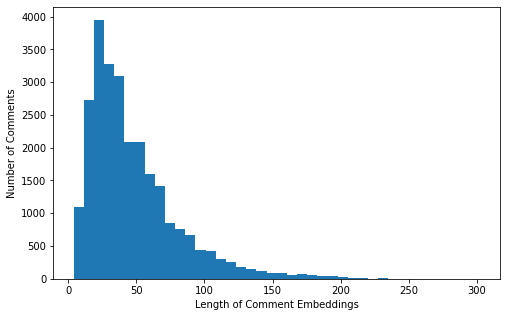

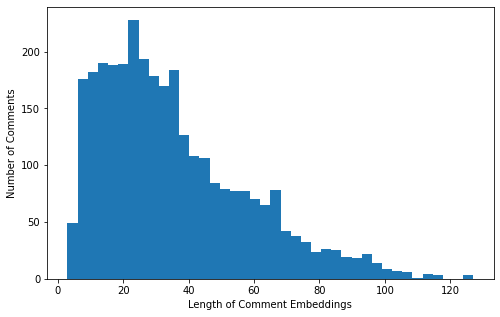

In [8]:
from transformers import XLNetTokenizerFast
tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased', do_lower_case=True)
for i in [X_train,X_test]:
 tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), i))
 tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
 fig, ax = plt.subplots(figsize=(8, 5));
 ax.hist(tokenized_texts_len, bins=40);
 ax.set_xlabel("Length of Comment Embeddings");
 ax.set_ylabel("Number of Comments");

In [9]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [10]:
train_input_ids = tokenize_inputs(X_train, tokenizer, num_embeddings=250)
test_input_ids = tokenize_inputs(X_test, tokenizer, num_embeddings=250)
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

In [11]:
d["features"] = train_input_ids.tolist() + test_input_ids.tolist()
d["masks"] = train_attention_masks + test_attention_masks
d.head()

,HATE_SPEECH,TARGET_LGBT+,TARGET_WOMEN,features,masks
0,"Women are basically childlike, they remain thi...",0,1,"[2696, 41, 6719, 863, 1970, 19, 63, 1313, 52, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Who the fuck are you? We are gutful sick of Va...,0,1,"[3501, 18, 15707, 41, 44, 82, 169, 41, 8839, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"Women are basically childlike, they remain thi...",0,1,"[2696, 41, 6719, 863, 1970, 19, 63, 1313, 52, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Who the fuck are you? We are gutful sick of Va...,0,1,"[3501, 18, 15707, 41, 44, 82, 169, 41, 8839, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,We began to break down when we allowed women t...,0,1,"[169, 402, 22, 1366, 151, 90, 80, 1124, 412, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [12]:
train, valid = train_test_split(d, test_size=0.2, random_state=42)
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()
train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()
label_cols = ["TARGET_LGBT+","TARGET_WOMEN"]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [13]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)
batch_size = 20
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [14]:
import time
import datetime

In [21]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  t0 = time.time()

  model.to(device)
  for i in trange(num_epochs, desc="Epoch"):
    actual_epoch = start_epoch + i
    model.train()
    tr_loss = 0
    num_train_samples = 0
    for step, batch in enumerate(train_dataloader):
      if step % 50 == 0 and not step == 0: 
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      optimizer.zero_grad()
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      loss.backward()
      optimizer.step()

    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))
    model.eval()
    eval_loss = 0
    num_eval_samples = 0
    for batch in valid_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [22]:
torch.cuda.empty_cache()

In [23]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [25]:
num_epochs=2

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/sexistdetect.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  Batch    50  of  1,164.    Elapsed: 0:01:56.
  Batch   100  of  1,164.    Elapsed: 0:03:53.
  Batch   150  of  1,164.    Elapsed: 0:05:49.
  Batch   200  of  1,164.    Elapsed: 0:07:45.
  Batch   250  of  1,164.    Elapsed: 0:09:41.
  Batch   300  of  1,164.    Elapsed: 0:11:37.
  Batch   350  of  1,164.    Elapsed: 0:13:33.
  Batch   400  of  1,164.    Elapsed: 0:15:29.
  Batch   450  of  1,164.    Elapsed: 0:17:25.
  Batch   500  of  1,164.    Elapsed: 0:19:21.
  Batch   550  of  1,164.    Elapsed: 0:21:18.
  Batch   600  of  1,164.    Elapsed: 0:23:14.
  Batch   650  of  1,164.    Elapsed: 0:25:10.
  Batch   700  of  1,164.    Elapsed: 0:27:06.
  Batch   750  of  1,164.    Elapsed: 0:29:02.
  Batch   800  of  1,164.    Elapsed: 0:30:59.
  Batch   850  of  1,164.    Elapsed: 0:32:55.
  Batch   900  of  1,164.    Elapsed: 0:34:51.
  Batch   950  of  1,164.    Elapsed: 0:36:48.
  Batch 1,000  of  1,164.    Elapsed: 0:38:44.
  Batch 1,050  of  1,164.    Elapsed: 0:40:41.
  Batch 1,100

Epoch:  50%|█████     | 1/2 [49:58<49:58, 2998.87s/it]

Saving model at epoch 0 with validation loss of 0.0006927594337371117


  Batch    50  of  1,164.    Elapsed: 0:51:55.
  Batch   100  of  1,164.    Elapsed: 0:53:52.
  Batch   150  of  1,164.    Elapsed: 0:55:48.
  Batch   200  of  1,164.    Elapsed: 0:57:45.
  Batch   250  of  1,164.    Elapsed: 0:59:41.
  Batch   300  of  1,164.    Elapsed: 1:01:38.
  Batch   350  of  1,164.    Elapsed: 1:03:34.
  Batch   400  of  1,164.    Elapsed: 1:05:30.
  Batch   450  of  1,164.    Elapsed: 1:07:27.
  Batch   500  of  1,164.    Elapsed: 1:09:23.
  Batch   550  of  1,164.    Elapsed: 1:11:20.
  Batch   600  of  1,164.    Elapsed: 1:13:16.
  Batch   650  of  1,164.    Elapsed: 1:15:13.
  Batch   700  of  1,164.    Elapsed: 1:17:09.
  Batch   750  of  1,164.    Elapsed: 1:19:05.
  Batch   800  of  1,164.    Elapsed: 1:21:02.
  Batch   850  of  1,164.    Elapsed: 1:22:58.
  Batch   900  of  1,164.    Elapsed: 1:24:55.
  Batch   950  of  1,164.    Elapsed: 1:26:51.
  Batch 1,000  of  1,164.    Elapse

Epoch: 100%|██████████| 2/2 [1:40:00<00:00, 3000.37s/it]

Valid loss: 0.0008059238671216843




Text(0.5, 1.0, 'Loss vs Number of Epochs')

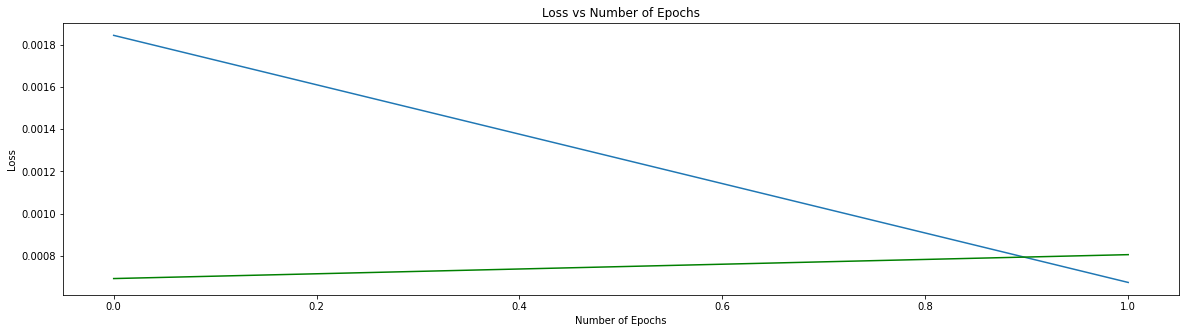

In [26]:
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(20, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [27]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/sexistdetect.bin")

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
model_save_name = 'detection.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [32]:
model.state_dict()

OrderedDict([('xlnet.mask_emb',
              tensor([[[-3.8489e-03,  5.2486e-03, -6.3917e-03, -1.8904e-03,  5.0990e-03,
                        -5.7584e-03, -7.6392e-03,  8.1679e-03,  4.7458e-03, -4.4163e-03,
                        -6.7998e-03,  9.4918e-03, -9.9556e-04, -7.6653e-03, -2.3268e-03,
                         1.3749e-04,  1.5165e-02, -5.7319e-03,  2.6785e-03,  6.4740e-03,
                         6.3571e-03, -6.1715e-03, -7.1400e-03, -3.8910e-02,  1.7696e-02,
                         9.2599e-03,  2.5634e-03,  4.6978e-03,  5.6817e-03, -9.1121e-04,
                         7.7846e-04,  8.9368e-03, -9.4092e-04, -7.0046e-03,  2.4308e-03,
                        -8.3177e-03,  1.7004e-03, -5.0066e-03, -3.9071e-03,  3.8386e-03,
                         2.1928e-02, -3.3668e-03,  5.0940e-03, -4.7822e-03, -1.4946e-02,
                        -4.6191e-03, -1.0626e-03,  4.5942e-04, -8.2133e-03,  7.4550e-04,
                         6.4538e-03, -1.4207e-02,  5.2352e-04,  1.8810e-03,  2

In [35]:
def generate_predictions(model, df, device="cpu", batch_size=16):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = []

  #model.to(device)
  #model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
#       pred_probs = np.vstack([pred_probs, logits])
      pred_probs.extend(logits.tolist())
        
  return pred_probs

In [36]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, valid, device="cuda", batch_size=16)
pred_probs

[[0.9999971389770508, 1.4582312815036858e-06],
 [0.999995231628418, 3.022272721864283e-06],
 [0.9999903440475464, 4.637961410480784e-06],
 [0.9999940395355225, 2.8567301342263818e-06],
 [0.9999943971633911, 2.5587673917470966e-06],
 [0.9999921321868896, 3.882789314957336e-06],
 [0.999990701675415, 4.6499726522597484e-06],
 [0.9999924898147583, 4.142266789131099e-06],
 [0.9999111890792847, 0.00010520582145545632],
 [0.9999967813491821, 1.8543487385613844e-06],
 [0.9999964237213135, 1.7303761978837429e-06],
 [0.9999955892562866, 2.472709866196965e-06],
 [0.9999935626983643, 3.221606903025531e-06],
 [0.9999819993972778, 1.3460183254210278e-05],
 [0.999994158744812, 2.790306780298124e-06],
 [0.9999916553497314, 4.21438835473964e-06],
 [0.9999954700469971, 2.19642379306606e-06],
 [0.9999964237213135, 2.0512165974650998e-06],
 [0.9999951124191284, 2.4205812678701477e-06],
 [0.9999943971633911, 2.851039198503713e-06],
 [0.9999954700469971, 2.0900979507132433e-06],
 [0.9999953508377075, 2.2153

In [37]:
valid

,HATE_SPEECH,TARGET_LGBT+,TARGET_WOMEN,features,masks
21444,This sub is not for trannies and their support...,1,0,"[122, 1466, 27, 50, 28, 17, 17201, 4789, 23, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3222,"Like others are saying, just don't - want a fu...",1,0,"[2386, 538, 41, 591, 19, 125, 220, 26, 46, 17,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2240,i give it 2 months tops before azealia has a t...,1,0,"[17, 150, 371, 36, 159, 399, 310, 23, 134, 24,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3172,Car was supported with jack stand buddy... Tha...,1,0,"[1561, 30, 2332, 33, 12323, 1434, 20555, 9, 9,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6481,"No, because we have class. Go fuck a dude faggot",1,0,"[336, 19, 149, 80, 47, 1075, 9, 1470, 15707, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...
24222,The only word that bothers me is faggot. Very ...,1,0,"[32, 114, 1139, 29, 8531, 23, 110, 27, 17, 281...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1554,"It's crazy how well they can fake it, my Lexus...",1,0,"[84, 26, 23, 5192, 160, 143, 63, 64, 7956, 36,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
25773,Surely older than you. Just not a PC faggot. ...,1,0,"[21783, 1839, 100, 44, 9, 1641, 50, 24, 3199, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
19555,That's just the half of it. There was trannies...,1,0,"[357, 26, 23, 125, 18, 455, 20, 36, 9, 238, 30...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [39]:
u = list(pred_probs)
v = []
vv = []
for i in u:
  if i[0] < 0.40 and i[1]<0.40:
    v.append(0)
    vv.append("Clear")
  elif i[0]>i[1]:
    v.append(round(i[0],4))
    vv.append("LGBT+")
  else:
    v.append(round(i[1],4))
    vv.append("WOMEN+")

In [40]:
uu = valid['HATE_SPEECH']
ans_frame = pd.DataFrame()
ans_frame['text'] = uu
ans_frame['tag'] = vv
ans_frame['probability'] = v

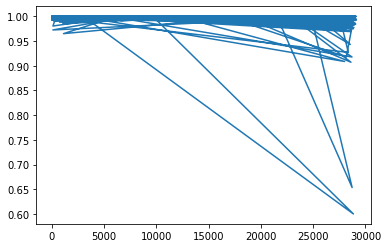

In [44]:
plt.plot(ans_frame['probability'])